## **Synthetic Image Generation, Preprocessing, and Flux Model Forward Pass**

Objective:
Demonstrate your ability to generate synthetic images using Stable Diffusion, perform basic image preprocessing, and set up a minimal Flux-based neural network to process an image (via a forward pass).


In [6]:
pip install diffusers torch torchvision transformers


1. Synthetic Image Generation
* Description:
Use a Stable Diffusion model (e.g., through Hugging Face’s diffusers library) to generate synthetic images based on a single text prompt of your choice.
* Requirements:
Choose one creative text prompt (for example, "a serene sunset over a futuristic city").
Generate at least 3 images using this prompt.

In [15]:
import torch
import time
import os
from datetime import datetime
from tqdm import tqdm
from diffusers import StableDiffusionPipeline


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device.upper()}")

#Model and Generation Settings
MODEL_NAME = "stabilityai/stable-diffusion-2-1"
PROMPT = "An ancient temple on solid ground, surrounded by golden clouds and waterfalls"
NUM_IMAGES = 3
NUM_INFERENCE_STEPS = 50
GUIDANCE_SCALE = 7.5
OUTPUT_DIR = "generated_img"
BATCH_SIZE = 1


os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    # Load Stable Diffusion Model ONCE
    print(f"Loading Stable Diffusion model: {MODEL_NAME}")
    start_time = time.time()
    pipeline = StableDiffusionPipeline.from_pretrained(MODEL_NAME)
    pipeline.to(device)
    print(f"Model loaded in {time.time() - start_time:.2f} seconds.\n")

    #Generate images
    print(f" Generating {NUM_IMAGES} images...")
    total_start_time = time.time()

    for i in tqdm(range(NUM_IMAGES), desc="Generating Images"):
        img_start_time = time.time()

        # Generate image
        image = pipeline(
            PROMPT,
            num_inference_steps=NUM_INFERENCE_STEPS,
            guidance_scale=GUIDANCE_SCALE
        ).images[0]

        # Generate filename
        image_filename = f"{OUTPUT_DIR}/synthetic_img_{i+1}.png"

        # Save image
        image.save(image_filename)
        print(f"Image {i+1} saved as {image_filename} in {time.time() - img_start_time:.2f}s")

    print(f"\n All {NUM_IMAGES} images generated in {time.time() - total_start_time:.2f} seconds.")

except torch.cuda.OutOfMemoryError:
    print("Error: CUDA Out of Memory! Try reducing `BATCH_SIZE` or `NUM_INFERENCE_STEPS`.")
except Exception as e:
    print(f"Unexpected Error: {e}")


 Using device: CUDA
Loading Stable Diffusion model: stabilityai/stable-diffusion-2-1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded in 2.85 seconds.

 Generating 3 images...


Generating Images:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 1/3 [01:04<02:09, 64.87s/it]

Image 1 saved as generated_img/synthetic_img_1.png in 64.87s


  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images:  67%|██████▋   | 2/3 [02:11<01:05, 65.90s/it]

Image 2 saved as generated_img/synthetic_img_2.png in 66.62s


  0%|          | 0/50 [00:00<?, ?it/s]

Generating Images: 100%|██████████| 3/3 [03:17<00:00, 65.95s/it]

Image 3 saved as generated_img/synthetic_img_3.png in 66.36s

 All 3 images generated in 197.86 seconds.


In [19]:
from google.colab import files
!zip -r generated_img.zip generated_img
files.download("generated_img.zip")


updating: generated_img/ (stored 0%)
updating: generated_img/synthetic_img_2.png (deflated 0%)
updating: generated_img/synthetic_img_3.png (deflated 0%)
updating: generated_img/synthetic_img_1.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2. Image Preprocessing
* Description:
Process the generated images to prepare them for model input.
* Requirements:
Resize each image to a consistent size (e.g., 224×224 pixels).
Convert the images to a normalized tensor format (for example, values scaled between 0 and 1).




Saved preprocessed image: preprocessed_img/synthetic_img_1.png


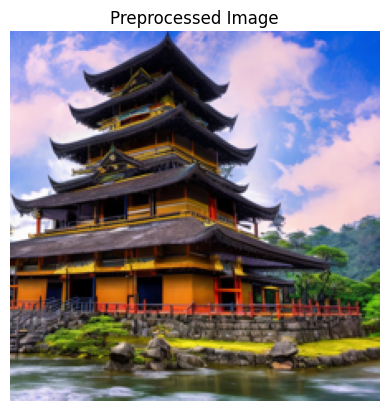

 Processed: synthetic_img_1.png - Shape: torch.Size([1, 3, 224, 224])
Saved preprocessed image: preprocessed_img/synthetic_img_2.png


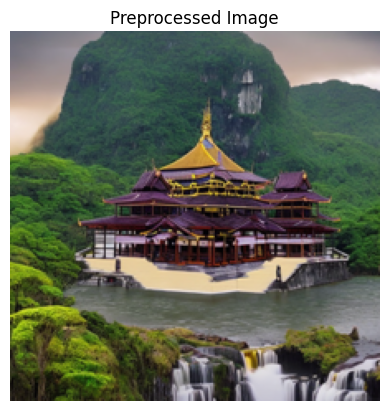

 Processed: synthetic_img_2.png - Shape: torch.Size([1, 3, 224, 224])
Saved preprocessed image: preprocessed_img/synthetic_img_3.png


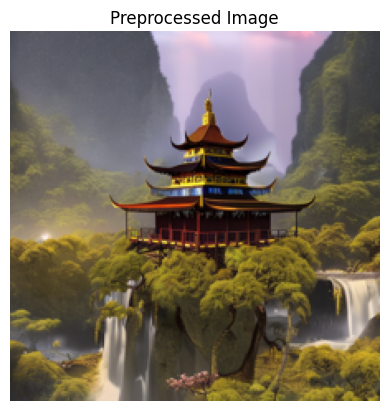

 Processed: synthetic_img_3.png - Shape: torch.Size([1, 3, 224, 224])

 Successfully processed 3 images!


In [20]:
import cv2
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image

#Define directories
image_dir = "generated_img"
output_dir = "preprocessed_img"
os.makedirs(output_dir, exist_ok=True)

def preprocess_image(image_path, save_path, grayscale=False, display=False):
    """
    Preprocess an image for deep learning model input.

    Steps:
    - Resize to (224, 224)
    - Convert to grayscale if required
    - Normalize pixel values (0 to 1)
    - Convert to PyTorch tensor with batch dimension
    - Save and optionally display the image

    Args:
    - image_path (str): Path to the image file.
    - save_path (str): Path to save the preprocessed image.
    - grayscale (bool): Convert to grayscale if True.
    - display (bool): Show the image if True.

    Returns:
    - torch.Tensor: Preprocessed image tensor.
    """
    try:
        # Load the image
        image = Image.open(image_path)

        # Convert to RGB if needed
        if not grayscale and image.mode != "RGB":
            image = image.convert("RGB")

        # Convert to grayscale if needed
        if grayscale:
            image = image.convert("L")

        # Resize to 224x224
        image = image.resize((224, 224))

        # Convert to numpy array and normalize (0-1)
        image_array = np.array(image, dtype=np.float32) / 255.0

        # Convert to tensor (Add channel dimension)
        if grayscale:
            image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)  # Shape: (1, H, W)
        else:
            image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)  # Shape: (3, H, W)

        # Add batch dimension (1, C, H, W)
        image_tensor = image_tensor.unsqueeze(0)

        #Save the preprocessed image
        preprocessed_img = Image.fromarray((image_array * 255).astype(np.uint8))  # Convert back to 0-255 range
        preprocessed_img.save(save_path)
        print(f"Saved preprocessed image: {save_path}")

        #Display the image (optional)
        if display:
            plt.imshow(image_array, cmap="gray" if grayscale else None)
            plt.axis("off")
            plt.title("Preprocessed Image")
            plt.show()

        return image_tensor

    except Exception as e:
        print(f" Error processing {image_path}: {e}")
        return None

# List of image filenames
image_filenames = [f"synthetic_img_{i+1}.png" for i in range(3)]

# Process all images and store tensors
preprocessed_images = []
for filename in image_filenames:
    image_path = os.path.join(image_dir, filename)
    save_path = os.path.join(output_dir, filename)

    if os.path.exists(image_path):
        tensor_image = preprocess_image(image_path, save_path, grayscale=False, display=True)  # Change to True for grayscale
        if tensor_image is not None:
            preprocessed_images.append(tensor_image)
            print(f" Processed: {filename} - Shape: {tensor_image.shape}")
    else:
        print(f" File not found: {filename}")

print(f"\n Successfully processed {len(preprocessed_images)} images!")


In [22]:
from google.colab import files
!zip -r preprocessed_img.zip preprocessed_img
files.download("preprocessed_img.zip")


  adding: preprocessed_img/ (stored 0%)
  adding: preprocessed_img/synthetic_img_2.png (deflated 0%)
  adding: preprocessed_img/synthetic_img_3.png (deflated 0%)
  adding: preprocessed_img/synthetic_img_1.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>